In [1]:
import requests
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Выгружаем наши данные для задания, таблицу с продажами по месяцам (df_sales)

dates = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS').strftime('%Y-%m-%d')

df_sales = pd.DataFrame({
    'date': dates,
    'sales': [5350, 5450, 5500, 4500, 4400, 3900, 3800, 4000, 4500, 4900, 5000, 5500]
})

In [3]:
# Сразу приведём дату в datetime

df_sales.date = pd.to_datetime(df_sales.date)

In [4]:
# Напишем интервал начала и конца
# Сделаем формат отображения как на сайте ЦБ РФ

start_date = df_sales['date'].min().strftime('%d.%m.%Y')
end_date = (df_sales['date'].max() + pd.offsets.MonthEnd(0)).strftime('%d.%m.%Y')

In [5]:
# Задаём ссылку и параметры запроса

url = "https://www.cbr.ru/hd_base/keyrate/"
data = {
    "UniDbQuery.Posted": "True",
    "UniDbQuery.From": start_date,
    "UniDbQuery.To": end_date
}

In [6]:
# Отправляем POST запрос на наш сайт
# Получает HTML-страницу с таблицей ставок за нужный период
# Ставим параметр кодировки 'utf-8' чтобы корректно читались русские буквы

response = requests.post(url, data=data)
response.encoding = 'utf-8'

In [7]:
# Оборачиваем текст в StringIO так как pandas выдал нам предупреждение
# о том что передача литерального html в 'read_html' устарела и будет удалена в будущей версии

html = StringIO(response.text)
df_rate = pd.read_html(html)[0]

In [8]:
df_rate

,Дата,Ставка
0,30.12.2024,2100
1,28.12.2024,2100
2,27.12.2024,2100
3,26.12.2024,2100
4,25.12.2024,2100
...,...,...
251,09.01.2024,1600
252,08.01.2024,1600
253,05.01.2024,1600
254,04.01.2024,1600


In [9]:
# Обработаем наш df. Переименуем колонки

df_rate.columns = ['date', 'rate']

In [10]:
# Смотрим в каком формате данные

df_rate.dtypes

date    object
rate     int64
dtype: object

In [11]:
# Преобразуем дату в формат period(M) (%Y-%m) для группировки по месяцам
# Добавляем параметр dayfirst=True чтобы формат даты правильно отображался в pandas

df_rate['date'] = pd.to_datetime(df_rate['date'], dayfirst=True).dt.to_period('M')

In [12]:
# У нас ставка вывелась как число, нужно преобразовать её в проценты

df_rate['rate'] = df_rate['rate'] / 100

In [13]:
df_rate

,date,rate
0,2024-12,21.0
1,2024-12,21.0
2,2024-12,21.0
3,2024-12,21.0
4,2024-12,21.0
...,...,...
251,2024-01,16.0
252,2024-01,16.0
253,2024-01,16.0
254,2024-01,16.0


In [14]:
df_rate.dtypes

date    period[M]
rate      float64
dtype: object

In [15]:
# Группируем данные по максимальной ключевой ставке за месяц

df_rate = df_rate.groupby('date', as_index=False).agg({'rate': 'max'})

In [16]:
# Приведём формат даты обратно в datetime чтобы соединить две таблицы без ошибок

df_rate.date = df_rate['date'].dt.to_timestamp()

In [17]:
# Вернёмся к датафрейму df_sales

In [18]:
df_sales

,date,sales
0,2024-01-01,5350
1,2024-02-01,5450
2,2024-03-01,5500
3,2024-04-01,4500
4,2024-05-01,4400
5,2024-06-01,3900
6,2024-07-01,3800
7,2024-08-01,4000
8,2024-09-01,4500
9,2024-10-01,4900


In [19]:
# Соединяем две наши таблицы

df = df_sales.merge(df_rate, on='date', how='inner')

In [20]:
# Для удобства преобразуем даты в название месяцев

df.date = df.date.dt.month_name()

In [21]:
df

,date,sales,rate
0,January,5350,16.0
1,February,5450,16.0
2,March,5500,16.0
3,April,4500,16.0
4,May,4400,16.0
5,June,3900,16.0
6,July,3800,18.0
7,August,4000,18.0
8,September,4500,19.0
9,October,4900,21.0


In [22]:
# Для дальнейшего анализа используем визуализацию

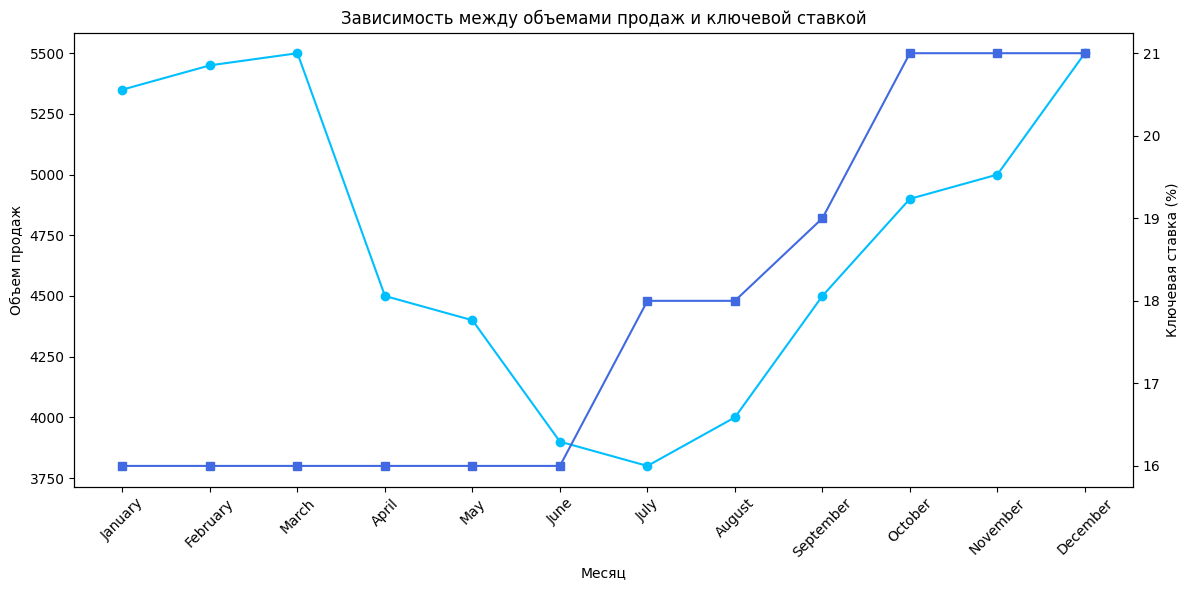

In [23]:
# Для визуального анализа тренда между объемом продаж от ставки ЦБ РФ, построим график сразу с двумя осями Y

fig, ax1 = plt.subplots(figsize=(12, 6))

# Ось Y1 — объем продаж
ax1.set_xlabel('Месяц')
ax1.set_ylabel('Объем продаж')
ax1.plot(df['date'].astype(str), df['sales'], color='deepskyblue', marker='o')
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', rotation=45)

# Ось Y2 — ключевая ставка
ax2 = ax1.twinx()
ax2.set_ylabel('Ключевая ставка (%)')
ax2.plot(df['date'].astype(str), df['rate'], color='royalblue', marker='s')
ax2.tick_params(axis='y')

plt.title('Зависимость между объемами продаж и ключевой ставкой')
fig.tight_layout()
plt.show()

In [24]:
# До июля ключевая ставка остаётся низкой, продажи постепенно снижаются
# С июля ставка и продажи начинает расти, наблюдается параллельный рост

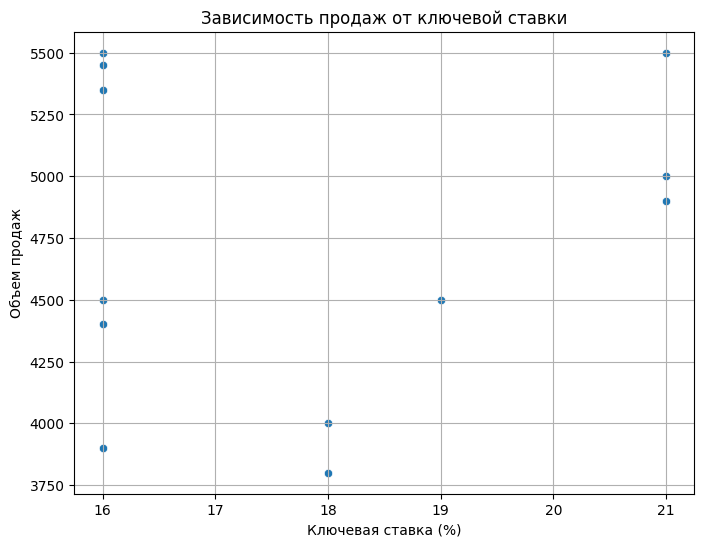

In [25]:
# Далее, чтобы оценить зависимость между двумя числовыми переменными,
# построим диаграмму рассеяния (scatter plot)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='rate', y='sales')
plt.title('Зависимость продаж от ключевой ставки')
plt.xlabel('Ключевая ставка (%)')
plt.ylabel('Объем продаж')
plt.grid(True)
plt.show()

In [26]:
# Точки на графике расположены отдельно, явной линейной зависимости не видно.
# Продажи колеблются как при низкой, так и при высокой ключевой ставке.
# Ключевая ставка не оказывает выраженного прямого влияния на продажи.

In [27]:
# Посчитаем коэффициент корреляции

correlation = df['sales'].corr(df['rate']).round(2)
print("Коэффициент корреляции:", correlation)
# Слабая корреляция

Коэффициент корреляции: 0.13


In [28]:
# Вывод по заданию:
# Анализ зависимости между ключевой ставкой и объёмом продаж показал, что прямой линейной связи не наблюдается.
# Коэффициент корреляции составляет 0.13, что указывает на очень слабую связь.
# Ключевая ставка за 2024 год не является основным фактором который влияет на продажи.